In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_openml

In [17]:
# Load the MNIST dataset and normalize the pixel values
pixels, label = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
label = label.astype(int)
pixels = np.where(pixels / np.max(pixels) > 0.5, 1, 0).astype(int)

dataframe = { "label": label, "pixels": [px for px in pixels] }
df = pd.DataFrame(dataframe)

data = df[df["label"] <= 2] # select only 0, 1, 2 values
dataset = data["pixels"].tolist()

N = len(dataset)
train, test = dataset[:int(N*0.8)], dataset[int(N*0.8):]
train_labels, test_labels = data["label"][:int(N*0.8)], data["label"][int(N*0.8):]

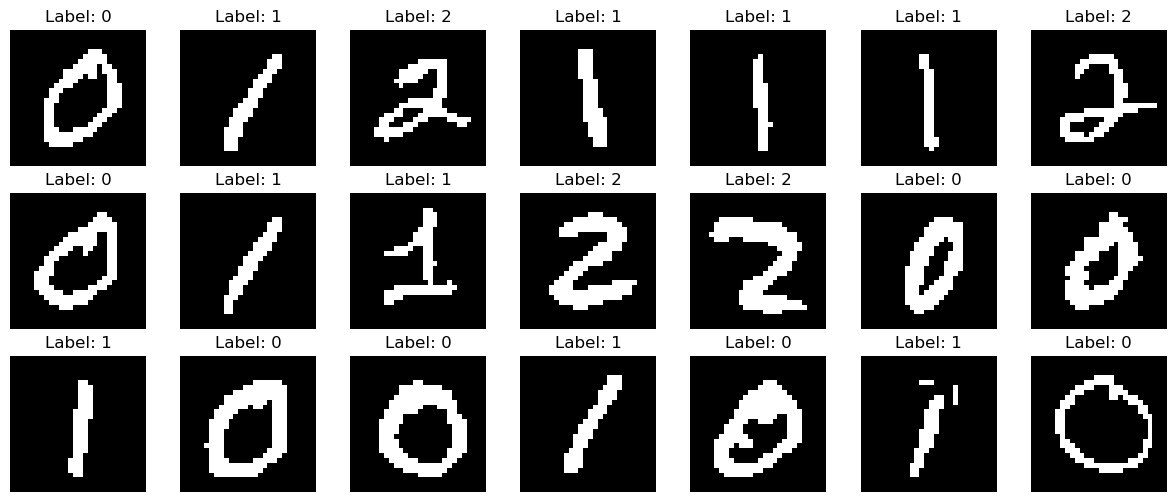

In [18]:
plt.figure(figsize=(15, 6))
for index, (image, label) in enumerate(zip(train[0:21], train_labels[0:21])):
    plt.subplot(3, 7, index + 1)
    plt.imshow(np.array(image).reshape(28, 28), cmap="gray")
    plt.axis("off")
    plt.title(f"Label: {label}")
plt.show()

In [19]:
def sigmoid(x):
    """Compute the sigmoid activation function."""
    x = np.clip(x, -500, 500)  # Avoid overflow
    return 1 / (1 + np.exp(-x))

def prob_h_given_v(b, W, v):
    """Compute the probability of hidden units given visible units."""
    return sigmoid(b + np.dot(W, v))

def prob_v_given_h(a, W, h):
    """Compute the probability of visible units given hidden units."""
    return sigmoid(a + np.dot(h, W))

In [20]:
def contrasting_divergence(v, W, a, b, k=1):
    '''
    Contrasting Divergence CD-k: Gibbs sampling for k steps
    sample v, and h from the conditional distribution p(v|h) and p(h|v)
    v0 -> h0 -> v1 -> h1 -> ...
    '''
    for _ in range(k):
        # Gibbs sampling using aceept-reject method from the conditional distribution
        h = (np.random.rand(len(b)) < prob_h_given_v(b, W, v)).astype(float)
        v = (np.random.rand(len(a)) < prob_v_given_h(a, W, h)).astype(float)
    h = (np.random.rand(len(b)) < prob_h_given_v(b, W, v)).astype(float)
    return v, h


def train_rbm(dataset, W, a, b, epochs, lr_initial=0.1, lr_final=0.01, lamb=0.0):
    """
    Train a Restricted Boltzmann Machine using Contrastive Divergence (CD-1).
    
    Parameters:
    - dataset: List or array of training samples, where each sample is a binary vector of size D.
    - W: Weight matrix of shape (L, D), where L is the number of hidden units and D is the number of visible units.
    - a: Bias vector for visible units, shape (D,).
    - b: Bias vector for hidden units, shape (L,).
    - epochs: Number of training epochs.
    - lr: Learning rate (default: 0.1).
    
    Returns:
    - W: Updated weight matrix.
    - a: Updated visible bias vector.
    - b: Updated hidden bias vector.
    """
    for epoch in range(epochs):
        
        # Learning rate schedule
        q = epoch / epochs
        lr = lr_initial * (1 - q) + q * lr_final

        E = []
        for v0 in dataset:
            h0 = (np.random.rand(len(b)) < prob_h_given_v(b, W, v0)).astype(float)
            v1, h1 = contrasting_divergence(v0, W, a, b, k=1)
            
            # Parameter updates
            W += lr * (np.outer(h0, v0) - np.outer(h1, v1))
            b += lr * (h0 - h1)
            a += lr * (v0 - v1)

            # Add L1 regularization to the weight updates
            if lamb > 0:
                W -= lr * lamb * np.sign(W)

            E.append(np.mean((v0 - v1)**2))
            
        print(f"Epoch {epoch + 1},\t lr = {lr:.2e}, error = {np.mean(E):.6f}")

    return W, a, b

def reconstruct(v, W, a, b, k=1):
    """Reconstruct a visible vector from the RBM."""
    v_recon, _ = contrasting_divergence(v, W, a, b, k)
    return v_recon

In [30]:
D = len(data["pixels"].values[0])   # number of visible nodes
L = 12                              # number of hidden nodes

# Initialize the weights and biases
# Hinton, 2012 
# W = np.random.normal(0, 0.01, (L, D))
a = np.zeros(D)
b = np.zeros(L)

# Glorot, 2010
W = np.random.normal(0, 2/np.sqrt(D+L), (L, D))
# Glorot (correct)
W = np.random.uniform(- np.sqrt(6)/ (np.sqrt(D+L)), np.sqrt(6)/ (np.sqrt(D+L)),(L, D))

np.random.seed(1234)
W, a, b = train_rbm(train, W, a, b, epochs = 50, lr_initial=0.3, lr_final=0.001, lamb=0)

Epoch 1,	 lr = 3.00e-01, error = 0.117168
Epoch 2,	 lr = 2.94e-01, error = 0.112899
Epoch 3,	 lr = 2.88e-01, error = 0.110826
Epoch 4,	 lr = 2.82e-01, error = 0.109448
Epoch 5,	 lr = 2.76e-01, error = 0.109397
Epoch 6,	 lr = 2.70e-01, error = 0.109376
Epoch 7,	 lr = 2.64e-01, error = 0.108752
Epoch 8,	 lr = 2.58e-01, error = 0.109355
Epoch 9,	 lr = 2.52e-01, error = 0.107951
Epoch 10,	 lr = 2.46e-01, error = 0.108426
Epoch 11,	 lr = 2.40e-01, error = 0.108484
Epoch 12,	 lr = 2.34e-01, error = 0.108171
Epoch 13,	 lr = 2.28e-01, error = 0.108264
Epoch 14,	 lr = 2.22e-01, error = 0.108470
Epoch 15,	 lr = 2.16e-01, error = 0.108273
Epoch 16,	 lr = 2.10e-01, error = 0.108640
Epoch 17,	 lr = 2.04e-01, error = 0.108354
Epoch 18,	 lr = 1.98e-01, error = 0.108285
Epoch 19,	 lr = 1.92e-01, error = 0.107688
Epoch 20,	 lr = 1.86e-01, error = 0.107932
Epoch 21,	 lr = 1.80e-01, error = 0.108215
Epoch 22,	 lr = 1.74e-01, error = 0.108046
Epoch 23,	 lr = 1.68e-01, error = 0.108044
Epoch 24,	 lr = 1.62

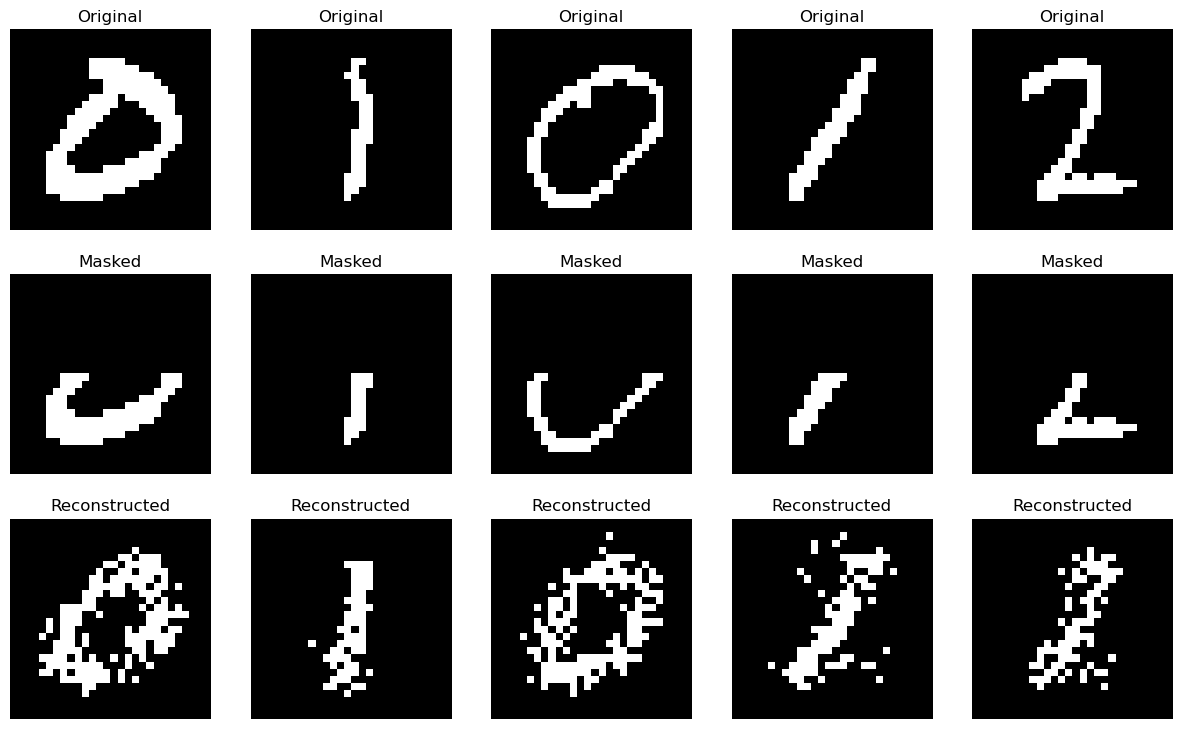

In [27]:
plt.figure(figsize=(15, 9))
for i, v in enumerate(test[20:25]):  # Show first 5 images
    v_masked = np.copy(v)
    v_masked[:len(v_masked) // 2] = 0  # Mask the lower half of the image

    # Reconstruct the image
    v_recon = reconstruct(v_masked, W, a, b, k=1)

    # Original image
    plt.subplot(3, 5, i + 1)
    plt.imshow(np.array(v).reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Masked image
    plt.subplot(3, 5, i + 6)
    plt.imshow(np.array(v_masked).reshape(28, 28), cmap="gray")
    plt.title("Masked")
    plt.axis("off")

    # Reconstructed image
    plt.subplot(3, 5, i + 11)
    plt.imshow(v_recon.reshape(28, 28), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()

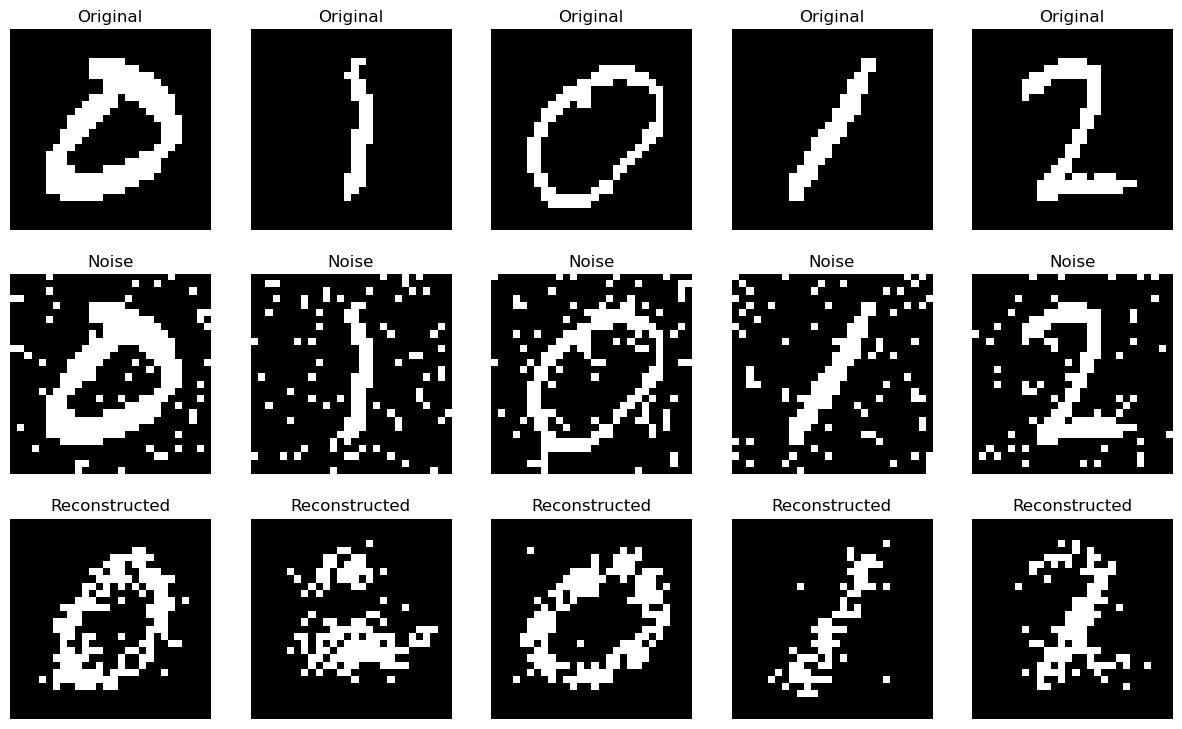

In [28]:
plt.figure(figsize=(15, 9))
for i, v in enumerate(test[20:25]):  # Show first 5 images
    v_noise = np.copy(v)
    v_noise += np.random.binomial(1, 0.1, size=v_noise.shape)
    v_noise = np.clip(v_noise, 0, 1)
    
    # Reconstruct the image
    v_recon = reconstruct(v_noise, W, a, b)

    # Original image
    plt.subplot(3, 5, i + 1)
    plt.imshow(np.array(v).reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Masked image
    plt.subplot(3, 5, i + 6)
    plt.imshow(np.array(v_noise).reshape(28, 28), cmap="gray")
    plt.title("Noise")
    plt.axis("off")

    # Reconstructed image
    plt.subplot(3, 5, i + 11)
    plt.imshow(v_recon.reshape(28, 28), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()

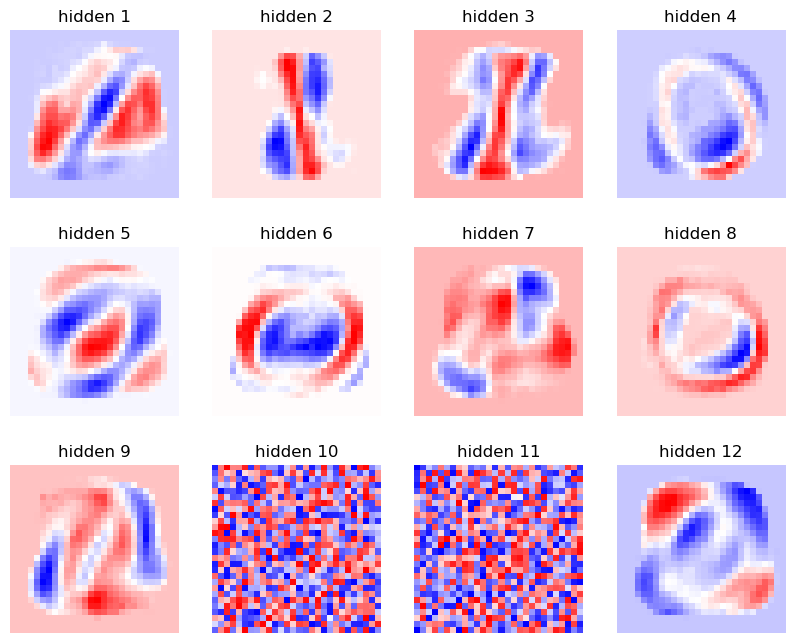

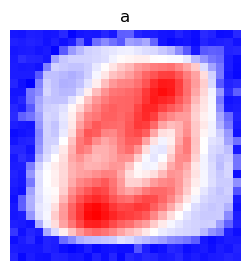

In [29]:
def plot_weights(W):
    """Plot the weights of the RBM as 28x28 images."""
    plt.figure(figsize=(10, 8))
    for i in range(W.shape[0]):  # Plot up to num_plots weights
        plt.subplot(3, 4, i + 1)
        weight_image = W[i].reshape(28, 28)
        plt.imshow(weight_image, cmap="bwr")
        plt.title(f"hidden {i+1}")
        plt.axis("off")
    plt.show()

def plot_visible_biases(a):
    """Plot the visible biases as a 28x28 image."""
    plt.figure(figsize=(3, 3))
    bias_image = a.reshape(28, 28)
    plt.imshow(bias_image, cmap="bwr")
    plt.title("a")
    plt.axis("off")
    plt.show()

plot_weights(W)
plot_visible_biases(a)